In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
import pandas as pd
mp.mp.dps = 30 #higher precision
import csv
import json
from PyMatching import *
import os

In [2]:
#pymatching to compare to
num_shots = 1000
Ls = [4,6]
ps = np.linspace(0.01, 0.15, 12)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for error_probability in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, error_probability, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=6...


In [3]:
#Log sum exp with arbitrary precision governed by mp
#In particular this gives infinite temperature version of the free energy, for scaling
def log_sum_exp(to_sum):
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res

#Free energy given histogram and temperature, arbitrary precision governed by mp
def free_energy(E_list, log_g_list,  T):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

#Run over batch of results, structured by seed, then by class
def get_free_energies(rescaled_results,temperatures):
    free_energies = []
    for seed_results in rescaled_results:
        free_energy_classes = []
        for error_result in seed_results:
            f_values = []
            for T in temperatures:
                f_values.append(free_energy(error_result[0], error_result[1], T)/(-T))
            free_energy_classes.append(f_values)
        free_energies.append(free_energy_classes)
    return free_energies

#For comparisons to MWPM algorithms
def get_lowest_energies(rescaled_results):
    lowest_energies = []
    for seed_results in rescaled_results:
        lowest_energy_classes = []
        for error_result in seed_results:
            e_values = min(error_result[0])
            lowest_energy_classes.append(e_values)
        lowest_energies.append(lowest_energy_classes)
    return lowest_energies

#For comparisons to MWPM algorithms
def get_lowest_g(rescaled_results):
    lowest_g = []
    for seed_results in rescaled_results:
        lowest_g_classes = []
        for error_result in seed_results:
            g_values = min(error_result[1])
            lowest_g_classes.append(g_values)
        lowest_g.append(lowest_g_classes)
    return lowest_g

In [4]:
import re

def read_results_file_without_comma_seperation(path):
    with open(path, 'r') as file:
        content = file.read()

    # Add a comma between each dictionary block
    content = content.strip()
    content = content.replace('}\n{', '},\n{')

    # Wrap the content in square brackets to make it a valid JSON array
    corrected_json = f'[{content}]'

    try:
        data = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")
        return None

    return data

def read_results_file(path):

    with open(path, 'r') as file:
        content = file.read()

    content = content.strip().rstrip(',')

    corrected_json = f'[{content}]'

    try:
        data = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        raise RuntimeError(f"Failed to parse JSON: {e}")


    return data

def parse_file(filename):
    data = []
    try:
        with open(filename, 'r') as file:
            content = file.read()
            # print("file content printout (for debugging):")
            # print(content)
    except FileNotFoundError:
        return

    # Split content into individual blocks
    blocks = content.split('}\n{')  # Assuming blocks are separated by double newlines

    for block in blocks:
        # Extract histogram_seed, run_seed, and results
        histogram_seed_match = re.search(r'"histogram_seed": "(\d+)"', block)
        run_seed_match = re.search(r'"run_seed": "(\d+)"', block)
        results_match = re.search(r'"results": \[([^]]*)\]', block)

        if histogram_seed_match and run_seed_match and results_match:
            histogram_seed = histogram_seed_match.group(1)
            run_seed = run_seed_match.group(1)
            results_str = results_match.group(1)

            # Process results
            results = {}
            results_items = results_str.split(',')
            for item in results_items:
                key_value = item.split(':')
                if len(key_value) == 2:
                    key = key_value[0].strip().strip('"')
                    value = float(key_value[1].strip())
                    results[key] = value

            data.append({
                "histogram_seed": histogram_seed,
                "run_seed": run_seed,
                "results": results
            })

    return data

def process_data(data, batch_results, p, size, error):
    for entry in data:
        histogram_seed = entry["histogram_seed"]
        run_seed = entry["run_seed"]
        results = entry["results"]

        E_list = []
        log_g_list = []

        # Process the results
        for key, value in results.items():
            E_list.append(int(key))
            log_g_list.append(float(value))

        batch_results.append({
                'prob': p,
                'size': size,
                'error': error,
                'histogram_seed': histogram_seed,
                'run_seed': run_seed,
                'E': E_list,
                'log_g': log_g_list
            })
        # offset = log_sum_exp(log_g_list)
        # print('deviation from sqrt(2)xy: ', mp.log(2)*size*size - offset, ' log sum exp:', offset)

def rescale_log_g(log_g_list, size):
    offset = log_sum_exp(log_g_list)
    rescaled_log_g_list = [res + mp.log(2) * size * size - offset for res in log_g_list]
    return rescaled_log_g_list


def check_condition(group):
    if len(group) != 4:
        return pd.Series({'There are still error classes missing': None})
    f_0000 = group.loc[group['error'] == '0000', 'free_energy'].values[0]

    f_others = group.loc[group['error'].isin(['0100', '1000', '1100']), 'free_energy']

    return pd.Series({'success': int(f_0000 < f_others.max())})

In [5]:
# read eight vertex bitflip limit results
batch_results = []
probabilities = [0.1, 0.11, 0.12]
sizes = [4, 5, 6]
intervals = [16]
iterations = 1000
overlap = 0.25
walkers = 8
alpha = 0.8
beta = 1e-8
exchange = 20

for interval in intervals:
    for p in probabilities:
        for size in sizes:
            for error in ["0000", "0100", "1000", "1100"]:
                filename = f"../results/eight_vertex/bit_flip_limit_with_color_hardcoded/prob_x_{p:.6f}/prob_y_0.000100/prob_z_0.000100/X_{size}_Y_{size}/error_class_{error}/StitchedHistogram__intervals_{interval}_iterations_{iterations}_overlap_{overlap:.6f}_walkers_{walkers}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset_{exchange}.txt"
                if os.path.exists(filename):
                    try:
                        data = read_results_file(filename)
                        if data:
                            process_data(data, batch_results, p, size, error)
                    except:
                        continue
print("eight vertex limit results: ", len(batch_results))

eight vertex limit results:  0


In [6]:

# Old eight vrtex limit reads
batch_results_without_color = []
probabilities = [0.1, 0.11, 0.12, 0.13]
sizes = [4, 6]
intervals = [16]
iterations = 1000
overlap = 0.25
walkers = 4
alpha = 0.8
beta = 1e-8
exchange = 10

for interval in intervals:
    for p in probabilities:
        for size in sizes:
            for error in ["0000", "0100", "1000", "1100"]:
                filename = f"../results/eight_vertex/bit_flip_limit/prob_x_{p:.6f}/prob_y_0.000100/prob_z_0.000100/X_{size}_Y_{size}/error_class_{error}/StitchedHistogram__intervals_{interval}_iterations_{iterations}_overlap_{overlap:.6f}_walkers_{walkers}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset_{exchange}.txt"
                if os.path.exists(filename):
                    try:
                        data = read_results_file(filename)
                        if data:
                            process_data(data, batch_results_without_color, p, size, error)
                    except:
                        data = read_results_file_without_comma_seperation(filename)
                        if data:
                            process_data(data, batch_results_without_color, p, size, error)
print("eight vertex limit results: ", len(batch_results_without_color))


eight vertex limit results:  119918


In [7]:
# # pure bitflip wl read
# walkers = 8
# exchange = 20

# batch_results_pure_bitflip = []

# for interval in intervals:
#     for p in probabilities:
#         for size in sizes:
#             for error in ["I", "X", "Y", "Z"]:
#                 filename = f"../results/periodic/prob_{p:.6f}/X_{size}_Y_{size}/error_class_{error}/StitchedHistogram_intervals_{interval}_iterations_{iterations}_overlap_{overlap:.6f}_walkers_{walkers}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset{exchange}.txt"
#                 if os.path.exists(filename):
#                     try:
#                         data = read_results_file(filename)
#                         if data:
#                             process_data(data, batch_results_pure_bitflip, p, size, error)
#                     except:
#                         print(f"no file {filename}")
# print("pure bit flip results: ", len(batch_results_pure_bitflip))

In [8]:
# Get free energies
batch_with_free_energy = []

batch_df = pd.DataFrame(batch_results)

batch_df['rescaled_log_g'] = batch_df.apply(lambda row: rescale_log_g(row['log_g'], row['size']), axis=1)
batch_df['free_energy'] = batch_df.apply(lambda row: free_energy(row['E'], row['rescaled_log_g'], 1/(mp.log((1-row['prob'])/row['prob'])/2))/(-(1/(mp.log((1-row['prob'])/row['prob'])/2))), axis=1)


ValueError: Cannot set a DataFrame without columns to the column rescaled_log_g

In [ ]:
batch_with_free_energy_without_color = []

batch_withour_color_df = pd.DataFrame(batch_results_without_color)

batch_withour_color_df['rescaled_log_g'] = batch_withour_color_df.apply(lambda row: rescale_log_g(row['log_g'], row['size']), axis=1)
batch_withour_color_df['free_energy'] = batch_withour_color_df.apply(lambda row: free_energy(row['E'], row['rescaled_log_g'], 1/(mp.log((1-row['prob'])/row['prob'])/2))/(-(1/(mp.log((1-row['prob'])/row['prob'])/2))), axis=1)


In [ ]:
# # Get free energies pure bitflip code
# batch_with_free_energy_pure_bitflip = []


# for result in batch_results_pure_bitflip:
#     E_list = result['E']

#     rescaled_log_g_list = rescale_log_g(result['log_g'], result['size']) # log(2)xy rescaling

#     T_Nish = 1/(mp.log((1-result['prob'])/result['prob'])/2)
#     T = T_Nish
#     # Compute the free energy
#     free_energy_value = free_energy(E_list, rescaled_log_g_list, T)/(-T) # -T as prefactor

#     # Add the computed free energy to the dictionary
#     result['free_energy'] = free_energy_value
#     result['rescaled_log_g'] = rescaled_log_g_list

#     # Add the updated dictionary to the list for DataFrame creation
#     batch_with_free_energy_pure_bitflip.append(result)

# # Create a DataFrame from the list of updated dictionaries
# batch_df_pure_bitflip = pd.DataFrame(batch_with_free_energy_pure_bitflip)

In [ ]:
grouped = batch_df.groupby(['prob', 'size', 'histogram_seed'])
filtered_groups = grouped.filter(lambda g: len(g)==4)
filtered_groups = filtered_groups.reset_index(drop=True)
grouped_for_logical_failures_df = filtered_groups.groupby(['prob', 'size', 'histogram_seed'])
success_df = grouped_for_logical_failures_df.apply(check_condition).reset_index()
logical_failure_rate_df = (
    success_df.groupby(['prob', 'size'])
    .agg(
        success_sum=('success', 'sum'),
        count=('success', 'size')
    )
    .reset_index()
)

# Calculate logical failure rate
logical_failure_rate_df['logical_failure_rate'] = 1 - (logical_failure_rate_df['success_sum'] / logical_failure_rate_df['count'])

print(logical_failure_rate_df)

   prob  size  success_sum  count  logical_failure_rate
0  0.10     4          139   4972              0.972043
1  0.10     5           92   4999              0.981596
2  0.10     6           75   5000              0.985000
3  0.11     4          197   4967              0.960338
4  0.11     5          139   5000              0.972200
5  0.11     6          106   5000              0.978800
6  0.12     4          258   4969              0.948078
7  0.12     5          197   5000              0.960600


/tmp/ipykernel_1481738/3212630641.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_df = grouped_for_logical_failures_df.apply(check_condition).reset_index()


In [ ]:
grouped_without_color = batch_withour_color_df.groupby(['prob', 'size', 'histogram_seed'])
filtered_grouped_without_color = grouped_without_color.filter(lambda g: len(g)==4)
filtered_grouped_without_color = filtered_grouped_without_color.reset_index(drop=True)
grouped_for_logical_failures_without_color_df = filtered_grouped_without_color.groupby(['prob', 'size', 'histogram_seed'])
success_without_color_df = grouped_for_logical_failures_without_color_df.apply(check_condition).reset_index()
logical_failure_rate_without_color_df = (
    success_without_color_df.groupby(['prob', 'size'])
    .agg(
        success_sum=('success', 'sum'),
        count=('success', 'size')
    )
    .reset_index()
)

# Calculate logical failure rate
logical_failure_rate_without_color_df['logical_failure_rate'] = 1 - (logical_failure_rate_without_color_df['success_sum'] / logical_failure_rate_without_color_df['count'])

print(logical_failure_rate_without_color_df)

   prob  size  success_sum  count  logical_failure_rate
0  0.11     4          204   4971              0.958962
1  0.11     6          110   5000              0.978000
2  0.12     4          258   4974              0.948130
3  0.12     6          159   5000              0.968200
4  0.13     4          319   4973              0.935854
5  0.13     6          235   5000              0.953000


/tmp/ipykernel_1481738/3758022235.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_without_color_df = grouped_for_logical_failures_without_color_df.apply(check_condition).reset_index()


In [ ]:

# nish_curve_dict = {}
# for p in probabilities:
#         if p != 0.1:
#                 for size in sizes:
#                         nish_curve = mp.mpf(1)
#                         subset = filtered_groups.loc[(filtered_groups['prob']==p) & (filtered_groups['size']==size)]
#                         for _, df_run in subset.groupby('histogram_seed'):
#                                 # Vectorized comparison for 'free_energy_nish_temp'
#                                 free_energy_I_nish = df_run.loc[df_run['error'] == '0000', 'free_energy'].values[0]
#                                 other_errors_nish = df_run.loc[df_run['error'] != '0000', 'free_energy']

#                                 nish_curve -= mp.mpf(int((free_energy_I_nish < other_errors_nish).any())) / mp.mpf(len(subset))
#                         nish_curve_dict[p, size]=nish_curve

In [ ]:
# nish_curve_dict

In [ ]:
# logical_failure_rate_df

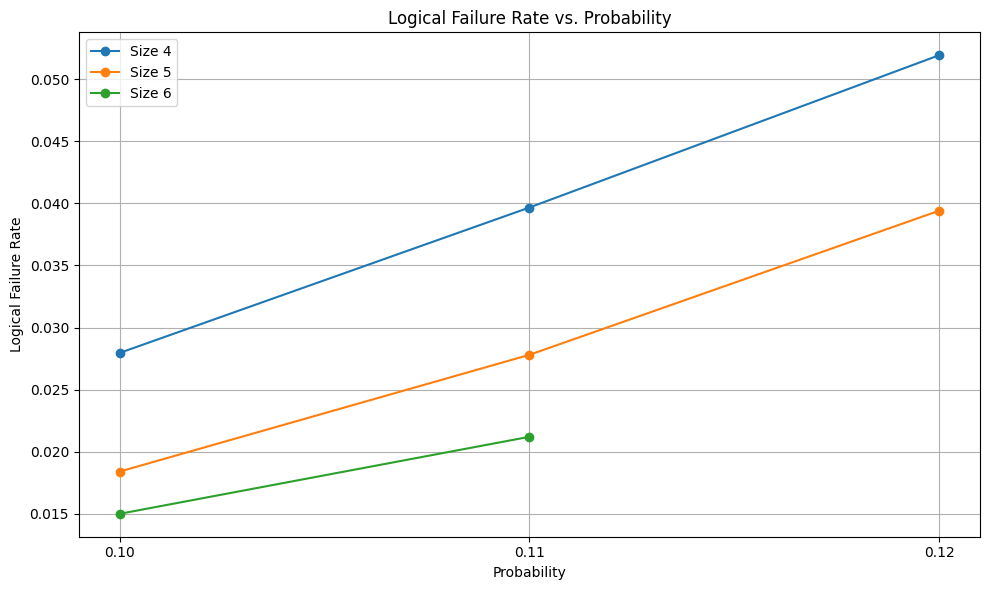

In [ ]:
plt.figure(figsize=(10, 6))

# Loop through sizes to plot each one
for size in logical_failure_rate_df['size'].unique():
    subset = logical_failure_rate_df[logical_failure_rate_df['size'] == size]
    plt.plot(subset['prob'], 1- subset['logical_failure_rate'], marker='o', label=f'Size {size}')

plt.title('Logical Failure Rate vs. Probability')
plt.xlabel('Probability')
plt.ylabel('Logical Failure Rate')
plt.legend()
plt.grid(True)
plt.xticks(logical_failure_rate_df['prob'].unique())  # Set x-ticks to the unique probabilities
plt.tight_layout()
plt.show()

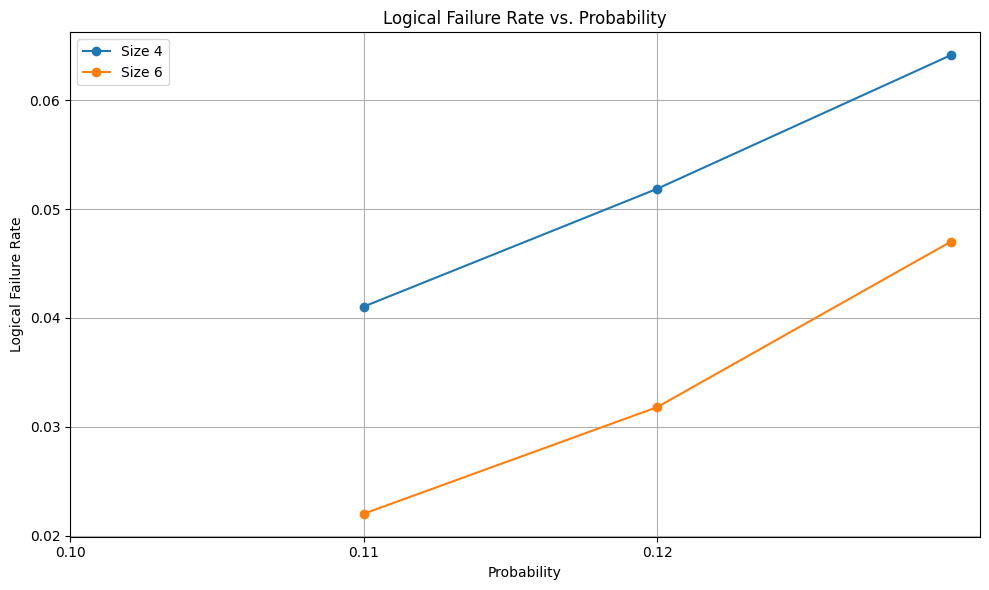

In [ ]:
plt.figure(figsize=(10, 6))

# Loop through sizes to plot each one
for size in logical_failure_rate_without_color_df['size'].unique():
    subset = logical_failure_rate_without_color_df[logical_failure_rate_without_color_df['size'] == size]
    plt.plot(subset['prob'], 1- subset['logical_failure_rate'], marker='o', label=f'Size {size}')

plt.title('Logical Failure Rate vs. Probability')
plt.xlabel('Probability')
plt.ylabel('Logical Failure Rate')
plt.legend()
plt.grid(True)
plt.xticks(logical_failure_rate_df['prob'].unique())  # Set x-ticks to the unique probabilities
plt.tight_layout()
plt.show()

Here is comparison of raw data between eight vertex and pure bitflip implementation

In [ ]:
batch_df_aggregated = batch_df
batch_df_aggregated['free_energy'] = batch_df_aggregated['free_energy'].astype(float)
batch_df_aggregated = batch_df_aggregated.groupby(['prob', 'size', 'error'])['free_energy'].agg(['mean', 'var']).reset_index()
display(batch_df_aggregated)

,prob,size,error,mean,var
0,0.10,4,0000,29.851364,6.884830
1,0.10,4,0100,27.024054,2.947730
2,0.10,4,1000,27.232593,2.338685
3,0.10,4,1100,25.721471,1.572579
4,0.10,5,0000,46.404733,10.209573
5,0.10,5,0100,42.808243,5.621242
6,0.10,5,1000,43.610152,3.675235
7,0.10,5,1100,41.358568,2.523313
8,0.10,6,0000,66.529040,14.448392
9,0.10,6,0100,62.256659,8.455630


In [ ]:

# batch_df_pure_bitflip['free_energy'] = batch_df_pure_bitflip['free_energy'].astype(float)
# batch_df_pure_bitflip_aggregated = batch_df_pure_bitflip.groupby(['prob', 'size', 'error'])['free_energy'].agg(['mean', 'var']).reset_index()
# display(batch_df_pure_bitflip_aggregated)

Here is old result handling with dict list

In [ ]:
from collections import defaultdict

# only keep results which come with all different error types:
#Changing structure to match postprocessing and plotting

# grouped dictionary with keys prob size and hist seed
grouped_results = defaultdict(list)
for result in batch_results:
    key = (result['prob'], result['size'], result['histogram_seed'])
    grouped_results[key].append(result)

In [ ]:
filtered_results = defaultdict(list)
for key, results in grouped_results.items():
    newkey = (key[0],key[1])
    errors = set(result['error'] for result in results)
    if errors == {"0000", "0100", "1000", "1100"}:
        # To be removed once normalization is properly handled in c
        for result in results:
            log_g_list = result['log_g']
            offset = log_sum_exp(log_g_list)
            rescaled_log_g_list = [res + mp.log(2)*key[1]*key[1] - offset for res in log_g_list]
            result['log_g'] = rescaled_log_g_list
        filtered_results[newkey].append([[result['E'], result['log_g']] for result in results])
    else:
        print(f"has issue with an error class prob: {key[0]} size: {key[1]} interaction seed: {key[2]} available errors: {errors}")

has issue with an error class prob: 0.1 size: 4 interaction seed: 2404 available errors: {'0000', '1100', '0100'}
has issue with an error class prob: 0.1 size: 4 interaction seed: 4365 available errors: {'0000', '1100', '0100'}
has issue with an error class prob: 0.1 size: 4 interaction seed: 465 available errors: {'0000', '1100', '0100'}
has issue with an error class prob: 0.1 size: 4 interaction seed: 3118 available errors: {'1000', '0000', '0100'}
has issue with an error class prob: 0.1 size: 4 interaction seed: 4242 available errors: {'0000', '1100', '0100'}
has issue with an error class prob: 0.1 size: 4 interaction seed: 3785 available errors: {'0000', '1100', '0100'}
has issue with an error class prob: 0.1 size: 4 interaction seed: 4332 available errors: {'0000', '1100', '0100'}
has issue with an error class prob: 0.1 size: 4 interaction seed: 4577 available errors: {'0000', '1100', '0100'}
has issue with an error class prob: 0.1 size: 4 interaction seed: 749 available errors: {

In [ ]:
sizes = [4, 5, 6]
probabilities = [0.1, 0.11, 0.12]

free_energies_batch = []
for p in probabilities:
    T_Nish = 1/(mp.log((1-p)/p)/2)
    temperatures = [1e-15,T_Nish,1e15]
    free_energies_size = []
    for size in sizes:
        batch_res = filtered_results[(p,size)]
        free_energies = get_free_energies(batch_res,temperatures)
        free_energies_size.append(free_energies)
        print('Number of seeds at p',p,', size',size,':', len(free_energies))
    free_energies_batch.append(free_energies_size)

Number of seeds at p 0.1 , size 4 : 4972
Number of seeds at p 0.1 , size 5 : 4999
Number of seeds at p 0.1 , size 6 : 5000
Number of seeds at p 0.11 , size 4 : 4967
Number of seeds at p 0.11 , size 5 : 5000
Number of seeds at p 0.11 , size 6 : 5000
Number of seeds at p 0.12 , size 4 : 4969
Number of seeds at p 0.12 , size 5 : 5000
Number of seeds at p 0.12 , size 6 : 0


In [ ]:
import scipy

optimal_curves = []
T0_curves = []

lower_bounds_T0 = []
upper_bounds_T0 = []

for i, p in enumerate(probabilities):
    optimal_curve = []
    T0_curve = []
    lower_bound_T0 = []
    upper_bound_T0 = []
    for j in range(len(sizes)):

       free_energies = free_energies_batch[i][j]

       if len(free_energies) == 0:
              continue

       #TO CHECK: if there is ever any significant difference between <= and < here
       #if so, should take degeneracy into account, and count with fraction if <=
       #Seems not to be an issue though
       temp = 1 #Nishimori temp
       res =  1 - mp.fsum([f_class[0][temp] < f_class[1][temp]\
              or f_class[0][temp] < f_class[2][temp]\
              or f_class[0][temp] < f_class[3][temp] for f_class in free_energies])/(len(free_energies))
       optimal_curve.append(res)

       temp = 0 #Low temp
       res =  1 - mp.fsum([f_class[0][temp] < f_class[1][temp]\
              or f_class[0][temp] < f_class[2][temp]\
              or f_class[0][temp] < f_class[3][temp] for f_class in free_energies])/(len(free_energies))
       T0_curve.append(res)

       number_success = round(len(free_energies) * res)
       number_failure = len(free_energies) - number_success

       lower_bound_T0.append(res-scipy.stats.beta.ppf(0.025, 0.5 + number_success, 0.5 + number_failure))
       upper_bound_T0.append(scipy.stats.beta.ppf(0.975, 0.5 + number_success, 0.5 + number_failure)-res)

    lower_bounds_T0.append(lower_bound_T0)
    upper_bounds_T0.append(upper_bound_T0)
    optimal_curves.append(optimal_curve)
    T0_curves.append(T0_curve)

In [ ]:
T0_curves

[[mpf('0.752212389380530973451327433628326'),
  mpf('0.808961792358471694338867773554711'),
  mpf('0.815000000000000000000000000000047')],
 [mpf('0.711294543990336219045701630763051'),
  mpf('0.759600000000000000000000000000012'),
  mpf('0.766999999999999999999999999999987')],
 [mpf('0.672569933588247132219762527671631'),
  mpf('0.709799999999999999999999999999992')]]

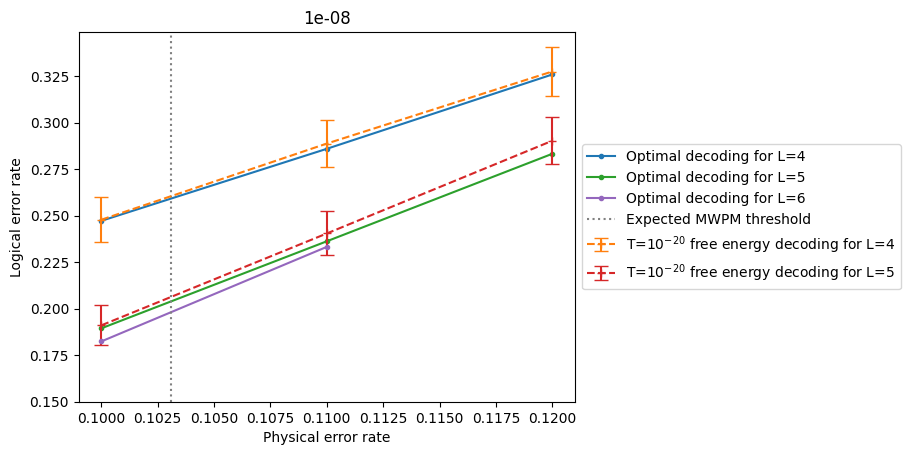

In [ ]:
plt.figure()
# for L, logical_errors in zip(Ls, log_errors_all_L):
#     std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
#     plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))


for i, size in enumerate(sizes):
    if i!=2:
        plt.plot(probabilities, [1-optimal_curves[j][i] for j in range(len(probabilities))],".-",label=r"Optimal decoding for L=%d"%size)
        # plt.plot(probabilities, [1-T0_curves[j][i] for j in range(len(probabilities))],"+--",label=r"T=$10^{-20}$ free energy decoding for L=%d"%size)
        plt.errorbar(probabilities, [1 - T0_curves[j][i] for j in range(len(probabilities))],
                 yerr=[[ upper_bounds_T0[j][i]  for j in range(len(probabilities))], [lower_bounds_T0[j][i] for j in range(len(probabilities))]],
                 fmt='+--', label=r"T=$10^{-20}$ free energy decoding for L=%d" % size, capsize=5)
    else:
        plt.plot(probabilities[:-1], [1-optimal_curves[j][i] for j in range(len(probabilities)-1)],".-",label=r"Optimal decoding for L=%d"%size)
        # plt.plot(probabilities, [1-T0_curves[j][i] for j in range(len(probabilities))],"+--",label=r"T=$10^{-20}$ free energy decoding for L=%d"%size)
        # plt.errorbar(probabilities, [1 - T0_curves[j][i] for j in range(len(probabilities)-1)],
        #          yerr=[[ upper_bounds_T0[j][i]  for j in range(len(probabilities)-1)], [lower_bounds_T0[j][i] for j in range(len(probabilities)-1)]],
        #          fmt='+--', label=r"T=$10^{-20}$ free energy decoding for L=%d" % size, capsize=5)


plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")

plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

#plt.xscale('log')
#plt.yscale('log')
plt.ylim(bottom=0.15, top=None)
plt.title(beta)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

IndexError: list index out of range

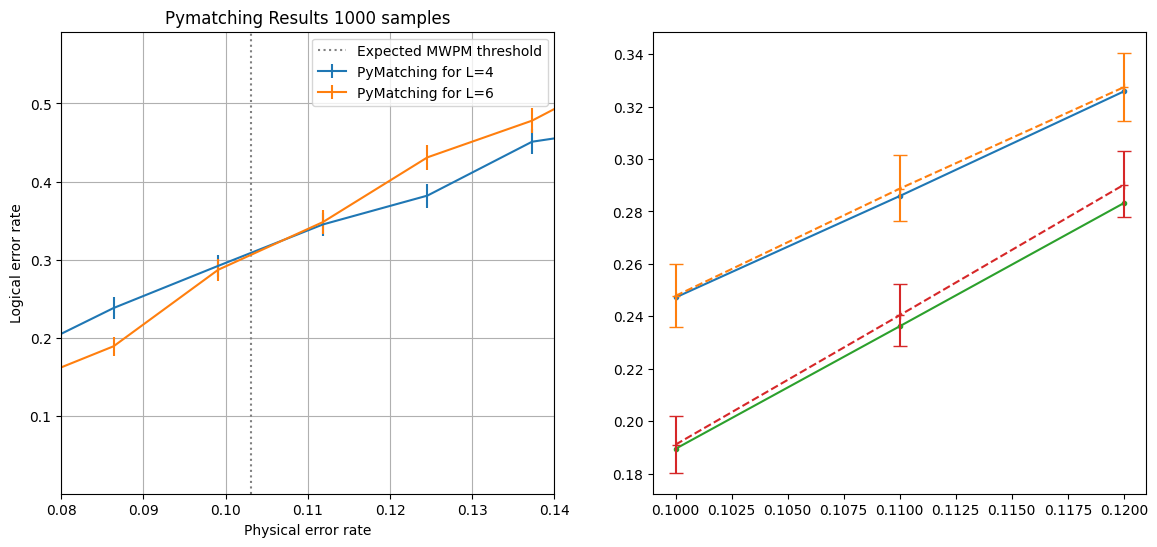

In [ ]:
# # Create a figure with two subplots (1 row, 2 columns)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# # Plot Pymatching results on the first subplot
# for L, logical_errors in zip(Ls, log_errors_all_L):
#     std_err = (logical_errors * (1 - logical_errors) / num_shots) ** 0.5
#     ax1.errorbar(ps, logical_errors, yerr=std_err, label=f"PyMatching for L={L}")

# ax1.axvline(x=0.1031, color="gray", label="Expected MWPM threshold", linestyle="dotted")
# ax1.set_xlabel("Physical error rate")
# ax1.set_ylabel("Logical error rate")
# ax1.set_ylim(bottom=1e-4, top=None)
# ax1.set_xlim(0.08, 0.14)
# ax1.set_title("Pymatching Results 1000 samples")
# ax1.legend()
# ax1.grid(True)

# # Plot the second loop results on the second subplot
# for i, size in enumerate(sizes):
#     ax2.plot(probabilities, [1 - optimal_curves[j][i] for j in range(len(probabilities))], ".-", label=f"Optimal decoding for L={size}")
#     ax2.errorbar(probabilities, [1 - T0_curves[j][i] for j in range(len(probabilities))],
#                  yerr=[[upper_bounds_T0[j][i] for j in range(len(probabilities))],
#                        [lower_bounds_T0[j][i] for j in range(len(probabilities))]],
#                  fmt='+--', label=f"T=$10^{{-20}}$ free energy decoding for L={size}", capsize=5)

# ax2.axvline(x=0.1031, color="gray", label="Expected MWPM threshold", linestyle="dotted")
# ax2.set_xlabel("Physical error rate")
# ax2.set_ylabel("Logical error rate")
# ax2.set_xlim(0.08, 0.14)
# ax2.set_ylim(bottom=1e-4, top=None)
# ax2.set_title("Bit Flip Limit of eight vertex 1000 interactions")
# ax2.legend()
# ax2.grid(True)

# # Adjust layout for better spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()

Include the random choice plots

In [ ]:
def mwpm_result(e_class):
    #Decoder picks a class based on lowest energy
    classes = [e_class[0],e_class[1],e_class[2],e_class[3]]
    i_max = classes.index(min(classes))

    #if i_max is not zero, decoder fails (we encountered a configuration with higher E than lowest)
    result = 0
    if i_max == 0:
        #If it is zero, decoder may succeed, but we need to account for that there could be several equivalent choices
        #We assume that the MWPM decoder will pick among the possible classes with equal probability
        result = 1/sum([x == min(classes) for x in classes])

    return result

def mwpm_result_new(e_class):
    #Decoder picks a class based on lowest energy
    classes = [e_class[0],e_class[1],e_class[2],e_class[3]]

    #If there are multiple classes with same lowest energy, pick one at random
    #We assume MWPM would find one at random, but most likely the sparse blossom
    #would prioritize some over others, since it takes advantage of being below threshold
    indices = list(np.where(np.asarray(classes) == min(classes))[0])
    i_max = np.random.choice(indices)

    #if i_max is not zero, decoder fails (picked other class than we're in)
    result = 0
    if i_max == 0:
        result = 1

    return result

def select_random_error_class(group):
    filtered_group = group[group['min_E'] == group['min_E_in_group']]
    if not filtered_group.empty:
        # Randomly select an 'error_class' value from the filtered rows
        selected_error = np.random.choice(filtered_group['error'])
        # Check if the selected error_class is '0000'
        return 1 if selected_error == '0000' else 0
    else:
        return 0



#j=1 is assumed to correspond to the Nishimori temperature
def mwpm_fraction(e_class, f_class):

    #Decoder picks a class based on lowest energy
    classes = [e_class[0],e_class[1],e_class[2],e_class[3]]
    i_max = classes.index(min(classes))

    #If there are several, decoder arbitrarily picks one at random
    indices = list(np.where(np.asarray(classes) == min(classes))[0])
    i_max = np.random.choice(indices)


    #We find the likelihood of actually being in that class
    #Here, convention is that j=1 is Nishimori, j=0 is T=0, other temperatures are j>1
    result = ((1/(mp.exp(f_class[0][1] - f_class[i_max][1])\
                  +mp.exp(f_class[1][1] - f_class[i_max][1])\
                  +mp.exp(f_class[2][1] - f_class[i_max][1])\
                  +mp.exp(f_class[3][1] - f_class[i_max][1]))))

    return result




def mwpm_result_using_degeneracy(e_class, g_class):
    #Decoder picks a class based on lowest energy
    classes = [e_class[0],e_class[1],e_class[2],e_class[3]]

    #If there are multiple classes with same lowest energy and degeneracy, list all
    indices = list(np.where(np.asarray(classes) == min(classes))[0])

    #Check among g_class for these indices which degeneracies are the largest
    g_classes = [g_class[i] for i in indices]


    indices2 = []
    for i in range(4):

        if i in indices and abs(g_class[i] - max(g_classes)) < 1e-10:
            indices2.append(i)

    if len(indices2)>1:
        print("Multiple classes with same degeneracy")

    #Finally pick one at random of those
    i_max = np.random.choice(indices2)

    #if i_max is not zero, decoder fails (picked other class than we're in)
    result = 0

    if i_max == 0:
        result = 1

    return result


mwpm_df = batch_df



mwpm_df['min_E'] = mwpm_df['E'].apply(min)
mwpm_df['min_log_g'] = mwpm_df['rescaled_log_g'].apply(min)

mwpm_df_with_transform = mwpm_df

# think about copy deep copy here





#     lowest_energies_4 = lowest_energies_batch[i][0]
#     lowest_energies_6 = lowest_energies_batch[i][1]

#     lowest_g_4 = lowest_g_batch[i][0]
#     lowest_g_6 = lowest_g_batch[i][1]

#     free_energies_4 = free_energies_batch[i][0]
#     free_energies_6 = free_energies_batch[i][1]

#     res1 = mp.fsum([mwpm_result(e_class) for e_class in lowest_energies_4 ])/len(lowest_energies_4)
#     res2 = mp.fsum([mwpm_result(e_class) for e_class in lowest_energies_6 ])/len(lowest_energies_6)
#     new_mwpm_curve.append([res1,res2])

#     res1 = mp.fsum([mwpm_fraction(e_class,f_class) for e_class, f_class in zip(lowest_energies_4, free_energies_4)])/len(lowest_energies_4)
#     res2 = mp.fsum([mwpm_fraction(e_class,f_class) for e_class, f_class in zip(lowest_energies_6, free_energies_6)])/len(lowest_energies_6)
#     new_mwpm_fraction_curve.append([res1,res2])

#     res1 = mp.fsum([mwpm_result_using_degeneracy(e_class,g_class) for e_class, g_class in zip(lowest_energies_4, lowest_g_4)])/len(lowest_energies_4)
#     res2 = mp.fsum([mwpm_result_using_degeneracy(e_class,g_class) for e_class, g_class in zip(lowest_energies_6, lowest_g_6)])/len(lowest_energies_6)
#     mwpm_degeneracy_curve.append([res1,res2])


In [ ]:

mwpm_df_with_transform['min_E_in_group'] = mwpm_df_with_transform.groupby(['prob', 'size', 'histogram_seed'])['min_E'].transform('min')


# mwpm_df_with_transform['min_log_g_in_group'] = mwpm_df_with_transform.groupby(['prob', 'size', 'histogram_seed'])['min_log_g'].transform('min')

mwpm_df_with_transform.groupby(['prob', 'size', 'histogram_seed']).filter(lambda g: len(g)==4)

# mwpm_df_with_transform['selected_error_class'] = mwpm_df_with_transform.groupby(['prob', 'size', 'histogram_seed']).apply(select_random_error_class).reset_index(drop=True)

# mwpm_df_select_random_min_energy_class = mwpm_df_with_transform.groupby(['prob', 'size'])['selected_error_class'].sum().reset_index()


,prob,size,error,histogram_seed,run_seed,E,log_g,rescaled_log_g,free_energy,min_E,min_log_g,min_E_in_group,min_log_g_in_group,selected_error_class
0,0.10,4,0000,4788,1,"[-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20]","[0.0, 2.050544120371342, 3.759544022381306, 5....","[3.76402931846728697406110979796, 5.8145734388...",25.8341227950583133864636173433,-20,3.76402931846728697406110979796,-24,1.30511873298207289871369148803,1.0
1,0.10,4,0000,1520,1,"[-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20]","[0.0, 1.663654275238514, 3.282053086906672, 4....","[4.23051557346352543031606446784, 5.8941698487...",26.2698685058852176147217260955,-20,4.15237944043346843525252526314,-24,0.70460521796582307271539291896,1.0
2,0.10,4,0000,3619,1,"[-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20]","[0.0, 2.013485316187143, 3.695124227553606, 5....","[3.8612372916838404210700584877, 5.87472260787...",25.9277775974016526895724839249,-20,3.81771362057833641981482097598,-24,0.663166977473427155864797608126,1.0
3,0.10,4,0000,1422,1,"[-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20]","[0.0, 1.994810149073601, 3.699893567711115, 4....","[3.85577062187291164788988155241, 5.8505807709...",25.9207628418021640715692207382,-20,3.85577062187291164788988155241,-24,0.651556627701225753695571502311,1.0
4,0.10,4,0000,1203,1,"[-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20]","[0.0, 2.05047620460391, 3.808471482247114, 5.1...","[3.66055792834425188505955147242, 5.7110341329...",25.7309868441076673675517727005,-20,3.66055792834425188505955147242,-20,2.2436600649234545317077790155,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159902,0.12,5,1100,1413,32,"[-32, -28, -24, -20, -16, -12, -8, -4, 0, 4, 8...","[0.0, 2.899461299180984, 5.384142121300101, 7....","[4.40787051144706208909550435366, 7.3073318106...",36.6404815311793603472692010481,-32,0.682340712209215204998679047474,-38,0.682340712209215204998679047474,NaN
159903,0.12,5,1100,1502,32,"[-32, -28, -24, -20, -16, -12, -8, -4, 0, 4, 8...","[0.0, 3.814885005354881, 6.473573669791222, 8....","[3.1562487967093290376383410799, 6.97113380206...",35.7790774789892811971319710039,-32,1.38338101280525297099053747983,-36,1.38338101280525297099053747983,NaN
159904,0.12,5,1100,3081,32,"[-32, -28, -24, -20, -16, -12, -8, -4, 0, 4, 8...","[0.0, 6.253806628286839, 8.969681667163968, 11...","[0.725088883124575928944724021808, 6.978895511...",35.2304656958485501005096208881,-32,0.725088883124575928944724021808,-34,0.725088883124575928944724021808,NaN
159905,0.12,5,1100,153,32,"[-38, -34, -30, -26, -22, -18, -14, -10, -6, -...","[0.0, 3.314354991540313, 5.606518801301718, 7....","[1.33815995375388891691873464426, 4.6525149452...",39.6779160828203349013202215391,-38,0.725801011125981895557723469228,-40,0.64157702392788462790132558804,NaN


In [ ]:
# mwpm_df.loc[mwpm_df['min_log_g'] != mwpm_df['min_log_g_in_group']].reset_index()
mwpm_df_with_transform.loc[mwpm_df['prob'] == 0.11].loc[mwpm_df['selected_error_class'].notna()]
# mwpm_df_with_transform[mwpm_df_with_transform['min_log_g'].isna()]

# display(mwpm_df_select_random_min_energy_class)

,prob,size,error,histogram_seed,run_seed,E,log_g,rescaled_log_g,free_energy,min_E,min_log_g,min_E_in_group,min_log_g_in_group,selected_error_class


In [ ]:
display(mwpm_df_with_transform.loc[(mwpm_df_with_transform['histogram_seed'] == '4788') & (mwpm_df_with_transform['size'] == 4) & (mwpm_df_with_transform['prob'] == 0.1)])

,prob,size,error,histogram_seed,run_seed,E,log_g,rescaled_log_g,free_energy,min_E,min_log_g,min_E_in_group,min_log_g_in_group,selected_error_class
0,0.1,4,0000,4788,1,"[-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20]","[0.0, 2.050544120371342, 3.759544022381306, 5....","[3.76402931846728697406110979796, 5.8145734388...",25.8341227950583133864636173433,-20,3.76402931846728697406110979796,-24,1.30511873298207289871369148803,1.0
6915,0.1,4,0100,4788,2,"[-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20]","[0.0, 2.847814302891493, 4.749163899570704, 6....","[2.86243273401592281947435872682, 5.7102470369...",25.0427858676784869557966373618,-20,2.78414884293411282191576497682,-24,1.30511873298207289871369148803,0.0
13210,0.1,4,1000,4788,3,"[-24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, ...","[0.0, 2.100236129015684, 4.5958889760077, 6.28...","[1.30511873298207289871369148803, 3.4053548619...",27.7824560939890738832200597265,-24,1.30511873298207289871369148803,-24,1.30511873298207289871369148803,1.0
16810,0.1,4,1100,4788,4,"[-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20]","[0.0, 2.895460672676563, 4.83232244849205, 6.0...","[2.77890804345764857687783244775, 5.6743687161...",24.9689531980318823418724723031,-20,2.71393631706990957577051926183,-24,1.30511873298207289871369148803,1.0
